In [1]:
import netgen.gui
%gui tk
from ngsolve import *
from netgen.geom2d import SplineGeometry


In [2]:
def MakeGeometry():
    geometry = SplineGeometry()
    
    # point coordinates ...
    pnts = [ (0,0), (1,0), (1,0.6), (0,0.6), \
             (0.2,0.6), (0.8,0.6), (0.8,0.8), (0.2,0.8), \
             (0.5,0.15), (0.65,0.3), (0.5,0.45), (0.35,0.3) ]
    pnums = [geometry.AppendPoint(*p) for p in pnts]
    
    # start-point, end-point, boundary-condition, domain on left side, domain on right side:
    lines = [ (0,1,1,1,0), (1,2,2,1,0), (2,5,2,1,0), (5,4,2,1,2), (4,3,2,1,0), (3,0,2,1,0), \
              (5,6,2,2,0), (6,7,2,2,0), (7,4,2,2,0), \
              (8,9,2,3,1), (9,10,2,3,1), (10,11,2,3,1), (11,8,2,3,1) ]
        
    for p1,p2,bc,left,right in lines:
        geometry.Append(["line", pnums[p1], pnums[p2]], bc=bc, leftdomain=left, rightdomain=right)

    geometry.SetMaterial(1,"base")
    geometry.SetMaterial(2,"chip")
    geometry.SetMaterial(3,"top")    

    return geometry

mesh = Mesh(MakeGeometry().GenerateMesh(maxh=0.2))


In [3]:
fes = H1(mesh, order=3, dirichlet=[1])
u = fes.TrialFunction()
v = fes.TestFunction()

# one heat conductivity coefficient per sub-domain
lam = CoefficientFunction([1, 1000, 10])
a = BilinearForm(fes)
a += SymbolicBFI(lam*grad(u)*grad(v))

# heat-source in inner subdomain
f = LinearForm(fes)
f += SymbolicLFI(CoefficientFunction([0, 0, 1])*v)

c = Preconditioner(a, type="multigrid", flags= {"inverse" : "sparsecholesky" })

gfu = GridFunction(fes)
Draw (gfu)

In [4]:
def SolveBVP():
    fes.Update()
    gfu.Update()
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec
    Redraw (blocking=True)

In [5]:
SolveBVP()

In [7]:
space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")

flux = lam * grad(gfu)
gf_flux.Set(flux)



In [8]:
err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
Draw(err, mesh, 'error_representation')

In [9]:
eta2 = Integrate(err, mesh, VOL, element_wise=True)
print(eta2)


 8.29527e-11
 2.76102e-08
 4.30874e-06
 5.51056e-11
 9.9237e-11
 1.04389e-07
 6.71168e-08
 2.05491e-07
 2.01376e-07
 9.10162e-09
 1.38102e-07
 2.59032e-07
 4.1139e-09
 6.38089e-11
 1.11165e-10
 1.93678e-07
 1.95124e-07
 2.19639e-07
 3.33617e-07
 1.9476e-10
 2.75099e-06
 2.82018e-06
 1.94308e-08
 7.23036e-11
 4.16706e-07
 3.51813e-09
 1.46782e-07
 7.35986e-08
 7.36518e-08
 2.54649e-06
 2.85403e-10
 2.37665e-10
 2.68309e-10
 8.94199e-10
 8.25576e-07
 5.43572e-07
 7.69331e-07
 4.0351e-07
 1.92988e-07
 2.0307e-07
 3.83832e-06
 9.16969e-10
 1.92183e-08
 7.10309e-09
 5.94227e-10
 1.7884e-09
 1.91099e-08
 1.66791e-08
 5.31563e-08
 1.36593e-08
 1.14483e-07
 3.58083e-08
 1.34567e-09
 1.56066e-10
 5.68704e-12
 4.02048e-12
 3.4852e-10
 5.74364e-13
 1.45869e-11
 5.91522e-12
 2.60765e-10
 7.07655e-07
 9.39162e-08



In [10]:
maxerr = max(eta2)
print ("maxerr = ", maxerr)

for el in mesh.Elements():
    mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)
    
Draw(gfu)


maxerr =  4.308744822522446e-06


In [11]:
mesh.Refine()
SolveBVP()
Redraw()

In [12]:
l = []    # l = list of estimated total error

def CalcError():

    # compute the flux:
    space_flux.Update()      
    gf_flux.Update()
    flux = lam * grad(gfu)        
    gf_flux.Set(flux) 
    
    # compute estimator:
    err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
    eta2 = Integrate(err, mesh, VOL, element_wise=True)
    maxerr = max(eta2)
    l.append ((fes.ndof, sqrt(sum(eta2))))
    print("ndof =", fes.ndof, " maxerr =", maxerr)
    
    # mark for refinement:
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)

In [13]:
CalcError()
mesh.Refine()

ndof = 490  maxerr = 2.5726475549350393e-06


In [14]:
while fes.ndof < 50000:  
    SolveBVP()
    CalcError()
    mesh.Refine()

ndof = 673  maxerr = 8.406009902856825e-07
ndof = 1240  maxerr = 3.0420776446828125e-07
ndof = 1945  maxerr = 2.459663354103721e-07
ndof = 2251  maxerr = 1.1238786235985826e-07
ndof = 2950  maxerr = 5.611243002086969e-08
ndof = 3361  maxerr = 2.8053935690242824e-08
ndof = 3889  maxerr = 1.4026565195114548e-08
ndof = 4606  maxerr = 7.01099346840072e-09
ndof = 5053  maxerr = 3.5040192671386635e-09
ndof = 5545  maxerr = 1.7512046128196403e-09
ndof = 6199  maxerr = 8.751503839528462e-10
ndof = 6739  maxerr = 4.373422760795708e-10
ndof = 7321  maxerr = 2.1855393469262913e-10
ndof = 8494  maxerr = 1.0921739030000271e-10
ndof = 9364  maxerr = 5.458316569881939e-11
ndof = 10201  maxerr = 2.7279569236942492e-11
ndof = 11521  maxerr = 1.3633641668854877e-11
ndof = 13318  maxerr = 6.813882297638386e-12
ndof = 14689  maxerr = 3.405288040284465e-12
ndof = 16651  maxerr = 1.701953485229202e-12
ndof = 19699  maxerr = 8.506338086619101e-13
ndof = 22459  maxerr = 4.25096378543791e-13
ndof = 26224  maxe

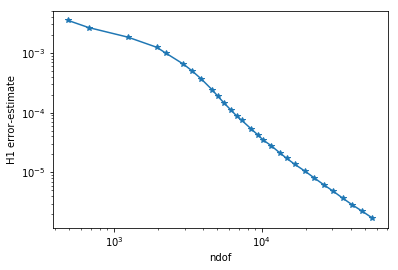

In [15]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("H1 error-estimate")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")

plt.ion()
plt.show()